In [158]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import os.path as op
from tqdm.notebook import tqdm
import re
import time
import ast

from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
from mpl_toolkits.basemap import Basemap

sys.path.insert(0, '..') # project folder

path_data = op.join('..', 'data', 'raw')
path_deriv = op.join(path_data, '..', 'derivatives')
path_metadata = op.join(path_data, "yt_metadata_en.jsonl.gz")
path_edu = op.join(path_deriv, "Education_videos_{}.csv")
path_channels = op.join(path_data, "df_channels_en.tsv.gz")

N_BATCHES = 8
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'), index_col=0, dtype={'country': str, 'channel_id': str})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Ideas
# bars of barplots are the flags
# flags as x ticks
# world map where you click on a country and it zooms to give you a detailed view on some stats for that country 
# piechart with categories

### Setup

In [159]:
channels = pd.read_csv(path_channels, compression="infer", sep="\t")
channels.rename(columns={'channel': 'channel_id'}, inplace=True)
channels.drop(columns=['weights'], inplace=True)
path_edu_classified = op.join(path_deriv, "Education_videos_{}_classified_{}.csv")

edu1 = pd.read_csv(path_edu_classified.format(7,1))
edu2 = pd.read_csv(path_edu_classified.format(7,2))
edu = pd.concat([edu1, edu2])
edu.drop(columns = ['Unnamed: 0', 'description', 'text', 'tags'], inplace = True)
edu.classified_labels = edu.classified_labels.apply(lambda x: x.split('\'')[1::2])

In [160]:
edu_countries = pd.merge(countries, edu, on='channel_id', how='outer')
edu_countries = edu_countries.astype({'country':'string'})
edu_countries = edu_countries.rename({'classified_labels': 'subcategory', 'categories':'vid_category', 'title':'vid_title'}, axis= 1)
edu_countries = pd.merge(channels, edu_countries, on='channel_id', how='outer')
# change column order 
new_order= ['category_cc', 'channel_id', 'name_cc', 'join_date', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'country', 'subcategory', 
       'vid_title', 'display_id', 'upload_date', 'duration', 'view_count', 'like_count', 'dislike_count', 'vid_category', 'crawl_date']

edu_countries = edu_countries[new_order]
edu_countries = edu_countries.dropna(axis=0, subset=['country'])    

edu_c = edu_countries[~edu_countries.country.isin(['deleted','no_rec', 'no_country'])]
edu_c = edu_c.dropna()

# TODO voir si on garde avec toute la data ou pas 
filter = 20
value_countss = edu_c['country'].value_counts()
edu_c.country = edu_c.country.apply(lambda x: 'Other' if value_countss[x] < filter  else x)
edu_c = edu_c[edu_c.country != 'Other']


def get_iso3(x):
    # pip install pycountry # https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes#
    import pycountry
    return pycountry.countries.get(alpha_2=x).alpha_3

edu_c['country_iso3'] = edu_c.country.apply(get_iso3)
edu_c.head()

,category_cc,channel_id,name_cc,join_date,subscribers_cc,videos_cc,subscriber_rank_sb,country,subcategory,vid_title,display_id,upload_date,duration,view_count,like_count,dislike_count,vid_category,crawl_date,country_iso3
3,Education,UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,2010-05-20,108000,81,151427.0,DE,[uncertain],"Subway Girls live jam - Kiss by Prince, Frankf...",HXm8ItPHiFs,2017-04-09 00:00:00,146.0,43919.0,472.0,18.0,Education,2019-11-05 04:56:07.143069,DEU
4,Education,UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,2010-05-20,108000,81,151427.0,DE,[uncertain],Cajon Guitar & Voice jam - Heidi Joubert + fri...,tyd_vhUpv9g,2017-02-27 00:00:00,174.0,22848.0,416.0,24.0,Education,2019-11-05 04:56:08.059424,DEU
5,Education,UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,2010-05-20,108000,81,151427.0,DE,[uncertain],Heidi Joubert - cajon & voice @ Guildhall Conc...,MJT5u_qQlvs,2016-12-08 00:00:00,224.0,14363.0,199.0,9.0,Education,2019-11-05 04:56:08.690804,DEU
6,Education,UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,2010-05-20,108000,81,151427.0,DE,"[lecture or academic course, entertaining expl...",Cajon Ec10m Roland Review Heidi Joubert Part 3...,L1-vc5cdETM,2016-11-02 00:00:00,234.0,17819.0,147.0,6.0,Education,2019-11-05 04:56:09.702099,DEU
7,Education,UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,2010-05-20,108000,81,151427.0,DE,[tutorial or DIY],Cajon Ec10m Roland Review Introduction & Part ...,CyASRjsrTJ8,2016-11-01 00:00:00,468.0,18870.0,133.0,6.0,Education,2019-11-05 04:56:10.768627,DEU


### Quick graph of channel distribution over countries

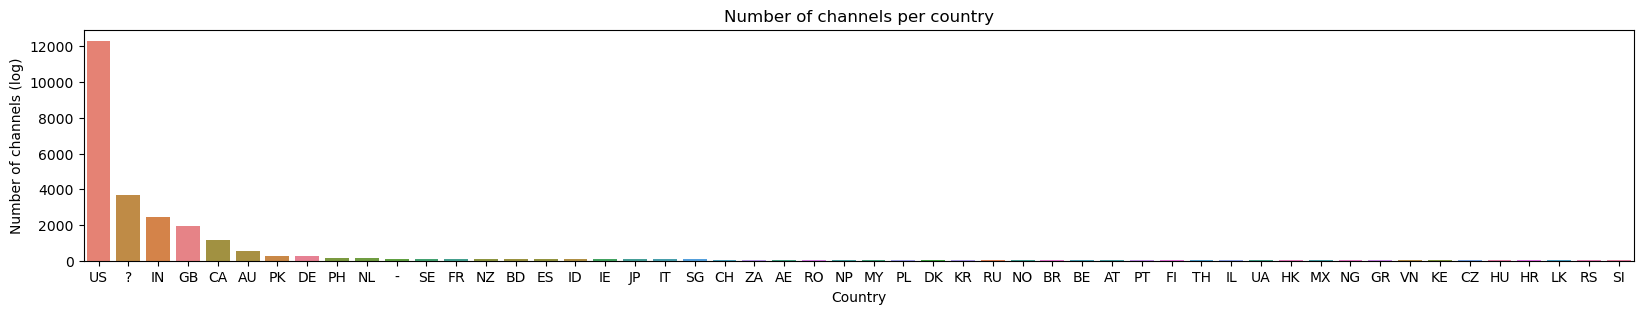

In [ ]:
#group in single category all the countries with less than 10 channels
to_plot = countries.copy()
filter = 20
value_countss = to_plot['country'].value_counts()
to_plot['country'] = to_plot['country'].apply(lambda x: 'Other' if type(x) == str and value_countss[x] < filter  else x)
to_plot = to_plot[to_plot.country != 'Other']

# deleted and no_rec we dont have information so question mark
to_plot[to_plot.country == 'deleted'] = '?'
to_plot[to_plot.country == 'no_country'] = '-'
to_plot[to_plot.country == 'no_rec'] = '?'
to_plot.country = to_plot.country.fillna('?') # just in case

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='country', data=to_plot, order = to_plot['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
#ax.legend_.remove()
plt.show()

# Categories

In [161]:
def get_labels(df, loc):
    list = df.loc[loc, 'subcategory'].values[0]
    return list
get_labels(edu_c, edu_c.display_id == 'x0BcdZrB7-A')

['lecture or academic course', 'conference']

In [162]:
print('With videos that have many categories: ', len(edu_c))
edu_short = edu_c.copy()
edu_short['single_class'] = edu_short.subcategory.apply(lambda x : 1 if len(x)== 1 else 2)
edu_short = edu_short[edu_short.single_class == 1].drop(columns='single_class')
edu_short.subcategory = edu_short.subcategory.apply(lambda x: x[0])
print('With videos that have a single categorie: ', len(edu_short)) 

With videos that have many categories:  365735
With videos that have a single categorie:  250049


In [163]:
edu_short.subcategory.value_counts()

subcategory
entertaining explanation or science popularization    64131
conference                                            36306
tutorial or DIY                                       34548
lecture or academic course                            28173
uncertain                                             28116
interview or Q&A or review                            27626
kids content                                          17437
misc                                                   9849
hacks                                                  2070
documentary                                            1793
Name: count, dtype: int64

In [164]:
name_change = {'entertaining explanation or science popularization': 'edutainment',
                'tutorial or DIY' : 'tutorial',
                'conference': 'conference',
                'interview or Q&A or review' : 'chatting',
                'uncertain': 'uncertain',
                'lecture or academic course' : 'school',
                'kids content': 'kids',
                'hacks' : 'hacks',
                'documentary': 'documentary',
                'misc': 'misc',
               }
edu_short.subcategory = edu_short.subcategory.apply(lambda x : name_change[x])

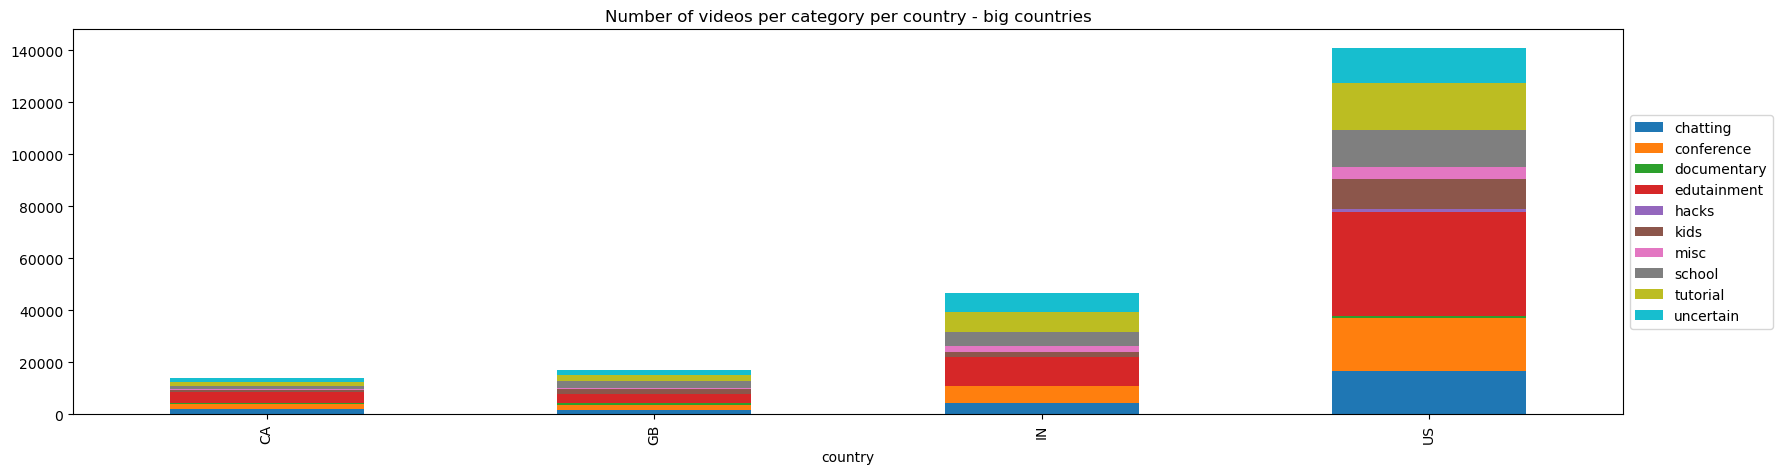

In [165]:
anglophone = ['IN','GB','CA','US']
big_fish = edu_short[edu_short.country.isin(anglophone)].groupby('country')
big_fish.subcategory.value_counts().unstack().plot(kind='bar', stacked=True, figsize=(20, 5), title='Number of videos per category per country - big countries')
ax = plt.gca()
#place legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

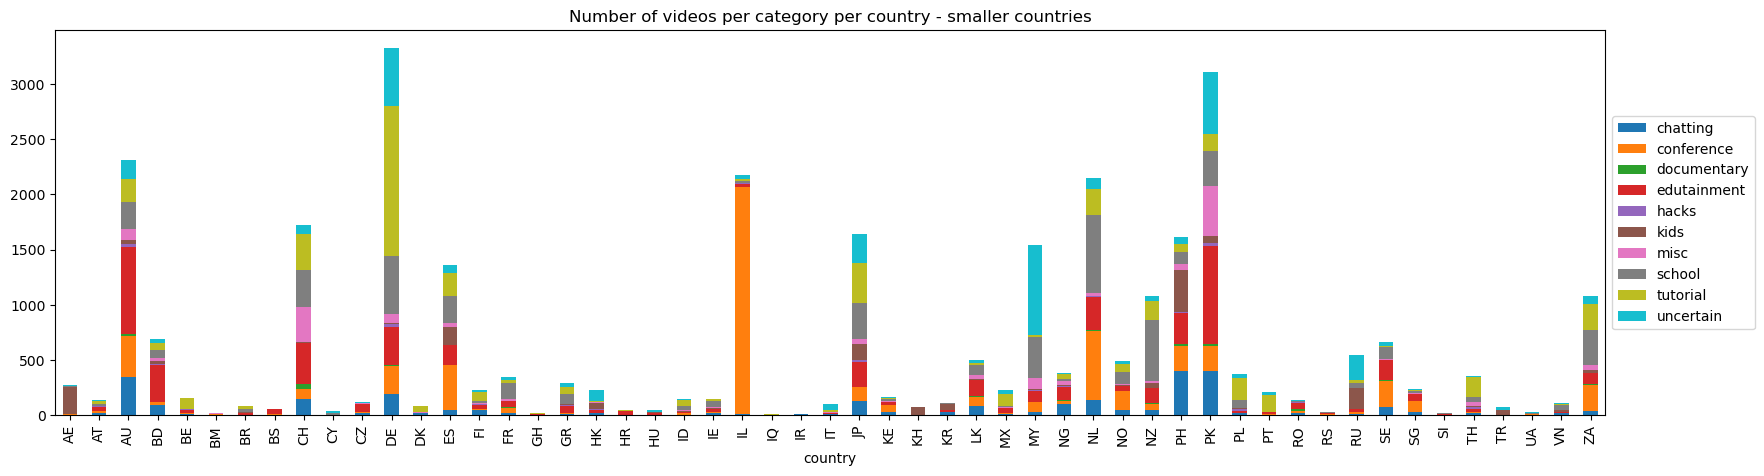

In [ ]:
small_fish = edu_short[~edu_short.country.isin(anglophone)].groupby('country')
small_fish.subcategory.value_counts().unstack().plot(kind='bar', stacked=True, figsize=(20, 5), title='Number of videos per category per country - smaller countries')
ax = plt.gca()
#place legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

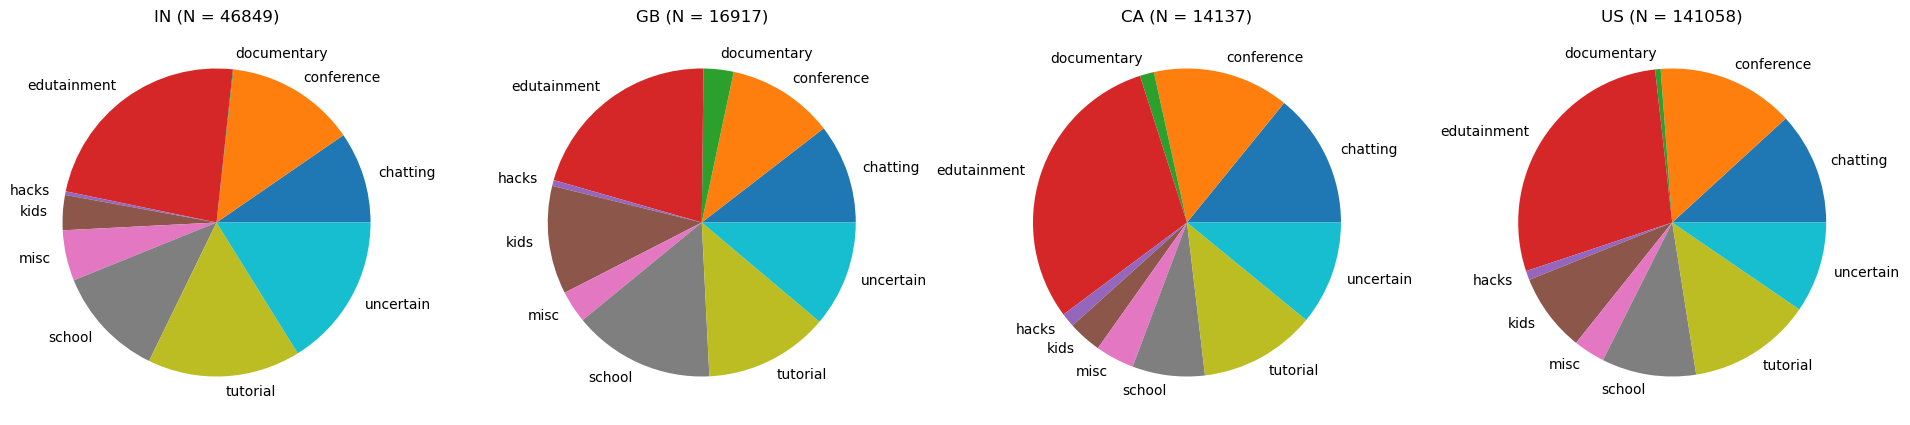

In [167]:
def plot_category_pie(countries, df, rows = 1):
    fig, ax = plt.subplots(rows,len(countries)//rows,figsize=(24, 5*rows))
    if rows > 1:
        ax = ax.flatten()
    df_sel = df[df.country.isin(countries)].groupby('subcategory')
    lengths = df_sel.country.value_counts().unstack().sum(axis=0)
    for i, country in enumerate(countries):
        df_sel.country.value_counts().unstack()[country].plot(kind='pie', stacked=True, title=country + f' (N = {int(lengths[country])})', ax = ax[i], legend =False, ylabel = '')
    return fig, ax

anglophone = ['IN','GB','CA','US']
fig, ax = plot_category_pie(anglophone, edu_short)
plt.show()

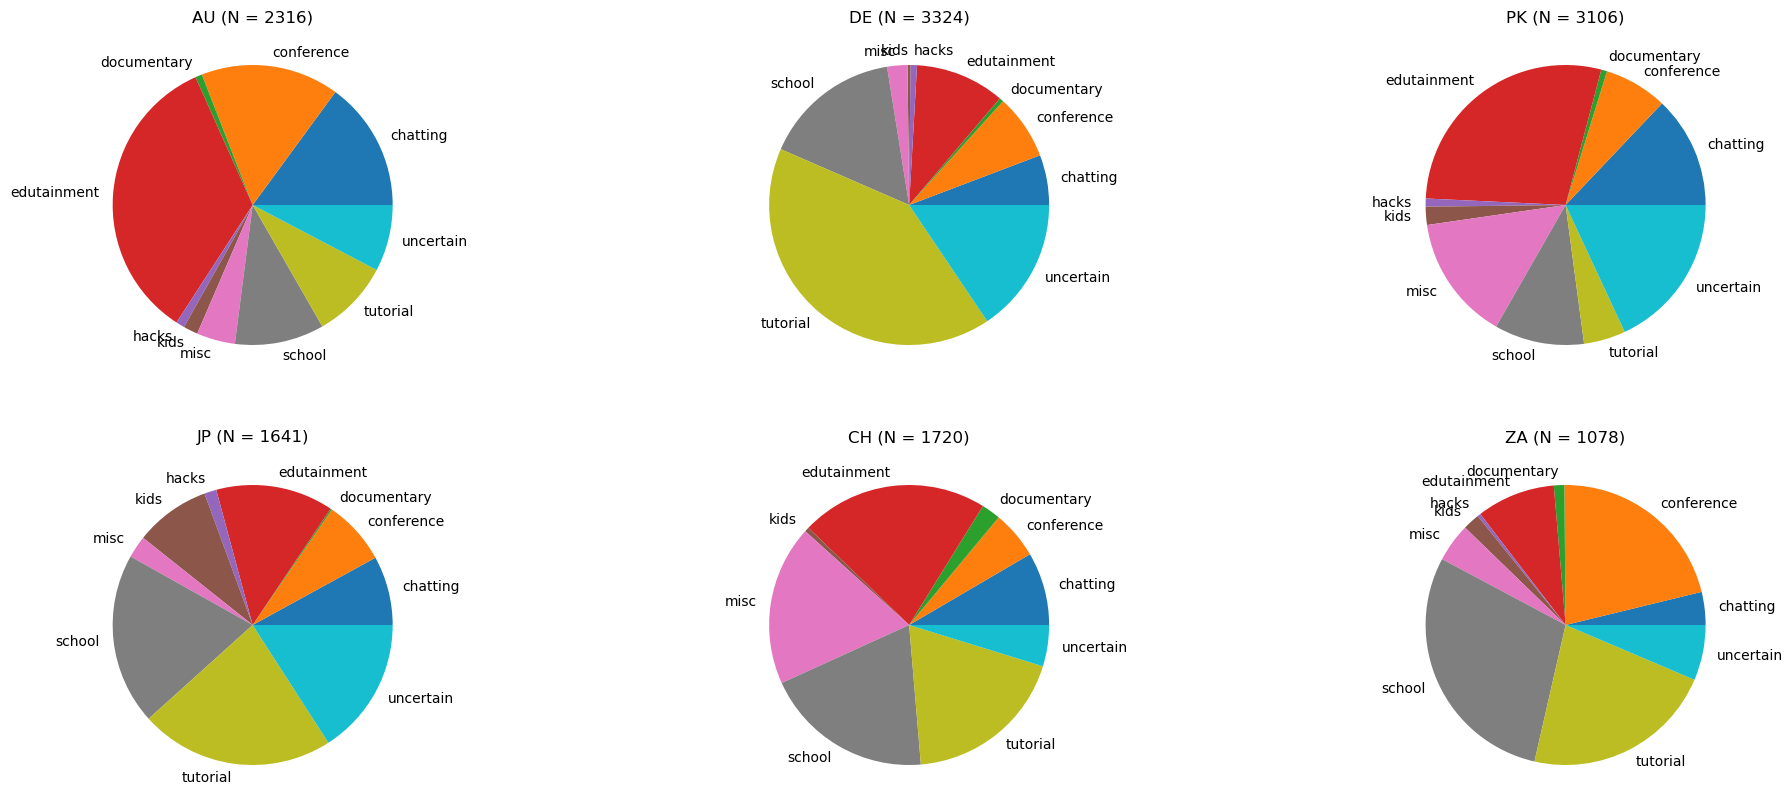

In [168]:
mezz0 = ['AU', 'DE', 'PK', 'JP', 'CH', 'ZA']
fig, ax = plot_category_pie(mezz0, edu_short, rows = 2)

## Numerical columns grouped by country - NOT all data 

In [95]:
edu_c.head(1)

,category_cc,channel_id,name_cc,join_date,subscribers_cc,videos_cc,subscriber_rank_sb,country,subcategory,vid_title,display_id,upload_date,duration,view_count,like_count,dislike_count,vid_category,crawl_date,country_iso3
3,Education,UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,2010-05-20,108000,81,151427.0,DE,[uncertain],"Subway Girls live jam - Kiss by Prince, Frankf...",HXm8ItPHiFs,2017-04-09 00:00:00,146.0,43919.0,472.0,18.0,Education,2019-11-05 04:56:07.143069,DEU


In [96]:
numericals_by_country = edu_c[['country','dislike_count', 'like_count','view_count','duration', 'videos_cc']].groupby(by='country')
pd.set_option("display.max_rows", 11)
display(numericals_by_country.mean().sort_values(by='country'))

,dislike_count,like_count,view_count,duration,videos_cc
country,,,,,
AE,623.323024,4230.206186,724820.319588,364.168385,278.027491
AT,20.184971,524.450867,63102.034682,846.104046,178.751445
AU,80.853926,1889.470621,129997.219660,631.982976,508.220758
BD,270.627551,3089.511905,227381.355442,607.646259,350.773810
BM,6.000000,57.166667,5420.958333,750.708333,322.000000
...,...,...,...,...,...
SI,1.054054,147.594595,4571.243243,339.783784,47.000000
TH,3.670732,328.060976,20984.042683,745.304878,406.219512
US,44.661637,574.999634,65851.816156,904.578283,5689.700295


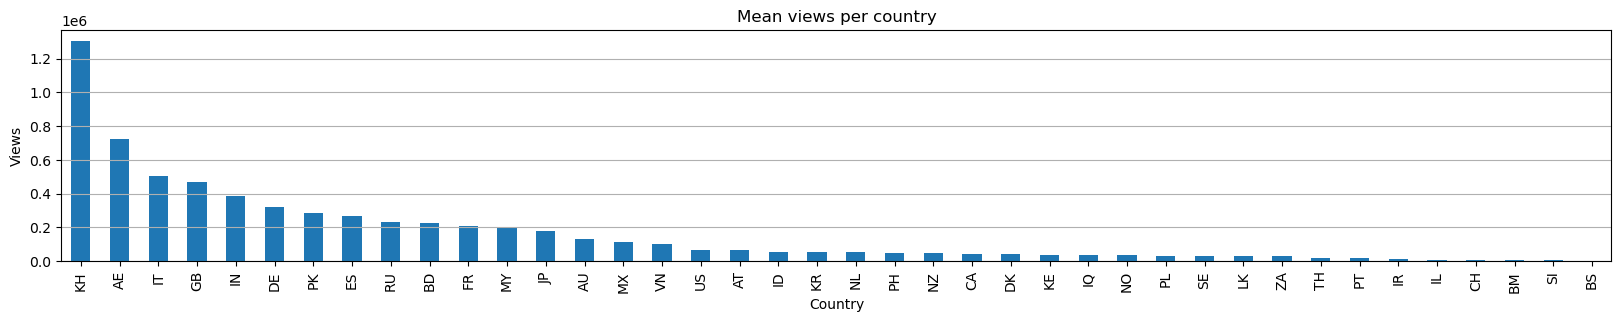

In [26]:
grouped_views = numericals_by_country.view_count
fig, ax = plt.subplots(figsize=(20, 3))

def plot_numerical_grouped_mean(grouped, ax, title, ylabel): 
    grouped.mean().sort_values(ascending=False).plot(kind='bar',ax=ax)
    plt.title(title)
    plt.xlabel('Country')
    plt.ylabel(ylabel)
    ax.yaxis.grid(True)
    return ax

ax = plot_numerical_grouped_mean(grouped_views, ax, 'Mean views per country', 'Views')

In [ ]:
grouped_likes = numericals_by_country.like_count
fig, ax = plt.subplots(figsize=(20,3))
ax = plot_numerical_grouped_mean(grouped_likes, ax, 'Mean likes per country', 'Likes')
# german are the ones that show the most appreciation

In [ ]:
grouped_dislikes = numericals_by_country.dislike_count
fig, ax = plt.subplots(figsize=(20,3))
ax = plot_numerical_grouped_mean(grouped_dislikes, ax, 'Mean dislikes per country', 'Dislikes')

In [ ]:
grouped_duration = numericals_by_country.duration
fig, ax = plt.subplots(figsize=(20,4))

ax = plot_numerical_grouped_mean(grouped_duration, ax, 'Mean duration per country', 'Duration (s)')

### Same histograms but with plotly and dash

In [132]:
from dash import Dash, html, dash_table, dcc, callback, Output, Input
numericals = edu_c[['country','dislike_count', 'like_count','view_count','duration', 'videos_cc']]

app = Dash()

app.layout = [
    html.Div(children='Numerical stats per country', style={'textAlign': 'center', 'color': 'black', 'fontSize': 30}),
    dcc.Dropdown(options = [{'label': subcategory.title().replace('_', ' '), 'value': subcategory} for subcategory in numericals.columns if subcategory != 'country'], value = 'view_count', id='dropdown-selection'),
    dcc.Graph(figure = {}, id='graph-content')
]

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)

def update_graph(value):
    if value != None:
        dff = numericals.groupby('country')[f'{value}'].mean().sort_values(ascending=False).reset_index()
        if value == 'duration':
            dff['duration'] = dff['duration']/60
        return px.bar(dff, x='country', y=value, title = f'Mean {value} per country', labels={'view_count':'Views'}, color='country')
    else:
        return px.bar()

In [133]:
import threading
import time
def run_app():
    app.run_server(mode='inline', debug=True, port = 8052)
thread = threading.Thread(target=run_app)
thread.start()

In [100]:
thread.join(timeout=0) # kill the thread, delete the graph above (clear cell outputs and run again to iteratively build your plot)

# Geographical plot

In [107]:
nb_channels = countries.groupby(['country']).count().reset_index().sort_values(by='channel_id', ascending=False).rename(columns={'channel_id': 'nb_channels'})
nb_channels = nb_channels[~nb_channels.country.isin(['Other', 'deleted', 'no_country', 'no_rec'])]
nb_channels['country_iso3'] = nb_channels.country.apply(get_iso3)
nb_channels.head()

,country,nb_channels,country_iso3
116,US,12312,USA
54,IN,2464,IND
42,GB,1963,GBR
23,CA,1165,CAN
9,AU,571,AUS


In [155]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

"""fig = px.choropleth(
    nb_channels,
    locations="country_iso3",        # Column with country names
    locationmode='ISO-3',       # Match on full country names       
    color="nb_channels",              # Numerical column to dictate color intensity
    color_continuous_scale="Plasma", # Color scale (options: 'Viridis', 'Plasma', etc.)
    title="Choropleth Example"
)
"""

fig = go.Figure(data=go.Choropleth(
    locations = nb_channels.country_iso3,
    z = nb_channels.nb_channels,
    #text = nb_channels.country,
    colorscale = 'Spectral',#'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color="RebeccaPurple",#'darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = '# channels',
))

fig.update_geos(
        showframe=True,
        showcoastlines=True, coastlinecolor="RebeccaPurple", coastlinewidth=0.8,
        showocean=True, oceancolor="LightBlue",
        showlakes=False, lakecolor="Blue",
        showrivers=False, rivercolor="Blue",
        showland=True, landcolor="#fff0db",
        projection_type='equirectangular'
    )

fig.update_layout(
    title_text='Number of channels per country',
    height=500, width = 1500, margin={"r":0,"t":30,"l":0,"b":0}
)
#fig.write_html('grass_map.html', auto_open=True)
fig.show()

### channels with the most views

In [78]:
pd.set_option("display.max_rows", 20)
most_views = edu_c.copy()   
most_views = most_views.groupby(['channel_id','name_cc', 'country']).view_count.sum().reset_index().sort_values(by='view_count', ascending=False).reset_index(drop=True)
most_views.head(15)

,channel_id,name_cc,country,view_count
0,UCsPF3cApzCohxPp5oKdoWSQ,CVS 3D Rhymes,IN,6.767252e+09
1,UCtgpDqkeOToveUgh8igrvXQ,KidsTV123,GB,3.869844e+09
2,UCsCe7SNQckiRJ6y563SIupg,Jugnu Kids - Nursery...,IN,2.191271e+09
3,UC0fXNmjDoC7ckPyT6qM8Urw,CBeebies,GB,1.115587e+09
4,UCs7on9W7SIbyO4f-Pb7lgbg,APPUSERIES,US,1.073740e+09
5,UCtlth0w7_mYqpHPViMhQ99Q,Oddbods - Official C...,US,1.029198e+09
6,UCsXVk37bltHxD1rDPwtNM8Q,Kurzgesagt – In a ...,DE,7.645073e+08
7,UCsE_m2z1NrvF2ImeNWh84mw,Active Self Protecti...,US,5.250591e+08
8,UC-lHB-Be9cqDDrfYvhuNpiA,Hindi ActionSongs,IN,5.000552e+08
9,UC-HOjVdbw0TG6h44rH4Sirw,Funny colors,ES,3.741997e+08


### Analysis of channels that did not indicate a country

In [ ]:
# in terms of views
no_country = edu_countries[edu_countries.country.isin(['no_country'])].drop(columns=['country'])
no_country = no_country.dropna(axis=0)
no_country = no_country.groupby(['channel_id','name_cc', 'category_cc','subscribers_cc','videos_cc']).view_count.sum(numeric_only=True).reset_index().sort_values(by='view_count', ascending=False).reset_index(drop=True)
no_country # pas assez juste avec ce dataset 

,channel_id,name_cc,category_cc,subscribers_cc,videos_cc,view_count
0,UCsT0YIqwnpJCM-mx7-gSA4Q,TEDx Talks,Nonprofits & Activism,20700000,141627,334482573.0
1,UC-g-wn12tbmgzcKNF8UXnyA,SageDynamics,Education,79100,406,8830998.0
2,UCs96xdizV6hOtBBvORGzdMg,davidmooretv,Entertainment,203000,124,127966.0
3,UC0KiGuCTrehqzSQ7ikjxSQw,Patricia Bright,Howto & Style,2800000,717,121462.0
4,UCsAgyTkuoKotY1AdXbOdIMA,Movies Ireland,Entertainment,23100,467,42940.0
5,UC-OO324clObi3H-U0bP77dw,SnoopDoggTV,People & Blogs,5470000,1439,16733.0
6,UCsNlFh-ibjU6mYpCnJx5IYg,LionBrandYarn,Howto & Style,80700,935,16552.0
7,UCsDUA6Kj4eMYyHsiJUxYGbA,SonicPAJ,Gaming,19800,134,3602.0


### channels w most educative videos - partial data

In [130]:
pedagogical = edu_c.groupby(['country', 'channel_id','name_cc', 'videos_cc']).vid_category.count().reset_index()
pedagogical['quota'] = pedagogical.apply(lambda x : x.vid_category/x.videos_cc if x.vid_category < x.videos_cc else 1, axis = 1)
pedagogical.sort_values(by='quota', ascending=False)

,country,channel_id,name_cc,videos_cc,vid_category,quota
386,IN,UCskSOSNR12wP3zoQmQPn0Yg,Indian School of Net...,75,77,1.000000
812,US,UC0N-iKBpHZlhSFu6BqLsHWQ,AV-Ultra,95,95,1.000000
501,PK,UC-0glaRVSX-yzC-0kj4k-rA,Urdu Main Sub Kuch S...,783,789,1.000000
38,AU,UCt_t6FwNsqr3WWoL6dFqG9w,BrainCraft,201,202,1.000000
305,IN,UC-lHB-Be9cqDDrfYvhuNpiA,Hindi ActionSongs,82,83,1.000000
...,...,...,...,...,...,...
147,FR,UC0KU8F9jJqSLS11LRXvFWmg,Ubisoft,10379,1,0.000096
546,US,UC-2Y8dQb0S6DtpxNgAKoJKA,PlayStation,11582,1,0.000086
361,IN,UCrwE8kVqtIUVUzKui2WVpuQ,Bharatiya Janata Par...,20692,1,0.000048
367,IN,UCsDb5pOn303kWylYMjlLUWA,New Waves,24201,1,0.000041


# TOOLS

In [17]:
pd.set_option("display.max_rows", None)

In [6]:
pd.set_option("display.max_rows", 11)

# Not used 

In [4]:
#from Gavin Rehkemper's dataset available at https://github.com/gavinr/world-countries-centroids
centroids = pd.read_csv(op.join(path_deriv, 'countries_centroids.csv'))
centroids.head()

,longitude,latitude,COUNTRY,ISO,COUNTRYAFF,AFF_ISO
0,-170.700732,-14.305712,American Samoa,AS,United States,US
1,166.638003,19.302046,United States Minor Outlying Islands,UM,United States,US
2,-159.787689,-21.222613,Cook Islands,CK,New Zealand,NZ
3,-149.400417,-17.674684,French Polynesia,PF,France,FR
4,-169.868781,-19.052309,Niue,NU,New Zealand,NZ


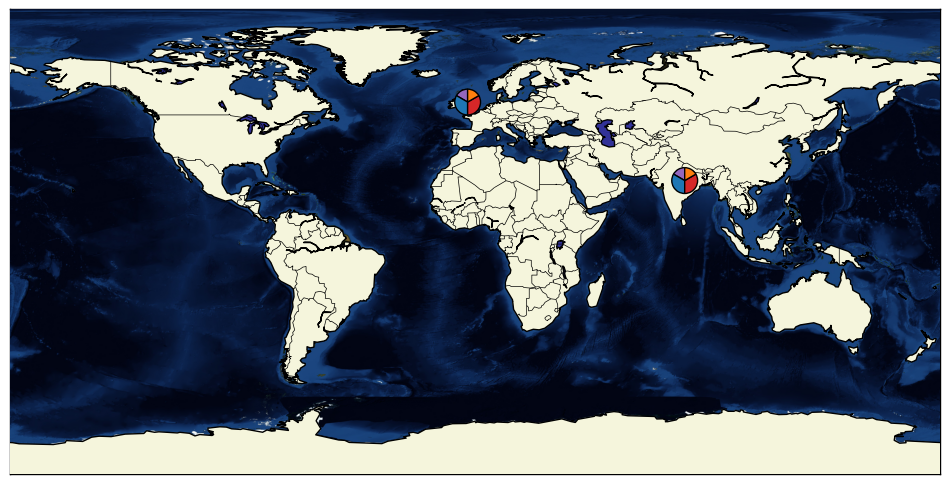

In [5]:
# Solution not kept

fig, ax = plt.subplots(figsize=(12, 8)) 
map = Basemap(projection='cyl', ax=ax)
map.bluemarble(zorder =1)
map.drawmapboundary(fill_color=None, zorder =0)
map.fillcontinents(color='beige',lake_color='#323298', zorder=2)
map.drawcountries(zorder=3)
map.drawcoastlines(zorder=4)

import matplotlib.patches as patches

def plot_pie_on_map(country, ax, cheese = [2, 4, 4, 2], radius = 5):
    # solution adapted from a ChatGPT suggestion
    country_c = centroids[centroids.ISO == country]
    lon, lat = country_c.longitude.values[0], country_c.latitude.values[0]
    x,y = map(lon,lat)
    colors = ["tab:purple", "tab:blue", "tab:red", "tab:orange"]
    angles = [size / sum(cheese) * 360 for size in cheese]
    current_angle = 90 # Start angle for first wedge
    
    for i, (size, color) in enumerate(zip(cheese, colors)):
        angle = angles[i]
        # Create wedge (like a pie chart slice)
        wedge = patches.Wedge(
            center=(x, y),        
            r=radius,               
            theta1=current_angle,  
            theta2=current_angle + angle,  
            facecolor=color,        
            edgecolor="black",      
            zorder=20               
        )
        ax.add_patch(wedge)
        current_angle += angle 

plot_pie_on_map('GB', ax)
plot_pie_on_map('IN', ax)

plt.show()
#https://basemaptutorial.readthedocs.io/en/latest/basemap3d.html

# ideas make the pie chart appear when you hover on top of the country, with a dot to show that data is available 
# make zooms on top of areas where the countries are smaller :
# SEE : https://basemaptutorial.readthedocs.io/en/latest/locator.html#inset-locator